## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [2]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 3
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [3]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [4]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    json_truth_set[key] = {
        'hybrid': 'HYBRID' in row['entry_name'], 
        'sequence': row['sequence']
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [5]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Initializing other processors...
Done.
Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 549/1086 spectra (50%)


## 3. Load in the fall off results

In [6]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

549

## 4. Run all analysis
1. Plot the number of results that fell into each category
2. Separate them by hybrid and non hybrd

### 4.1

In [7]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 4 artists>

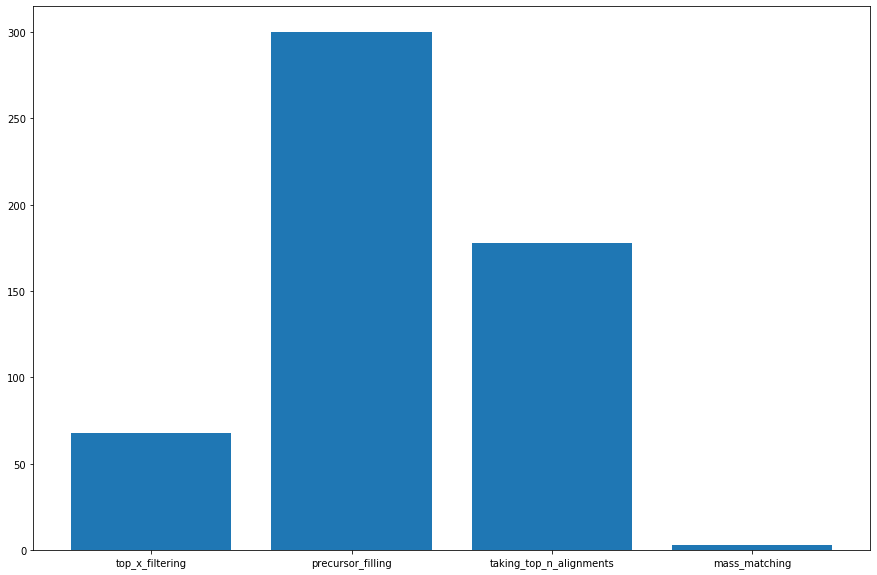

In [8]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### 4.2 by hybrid 

In [9]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

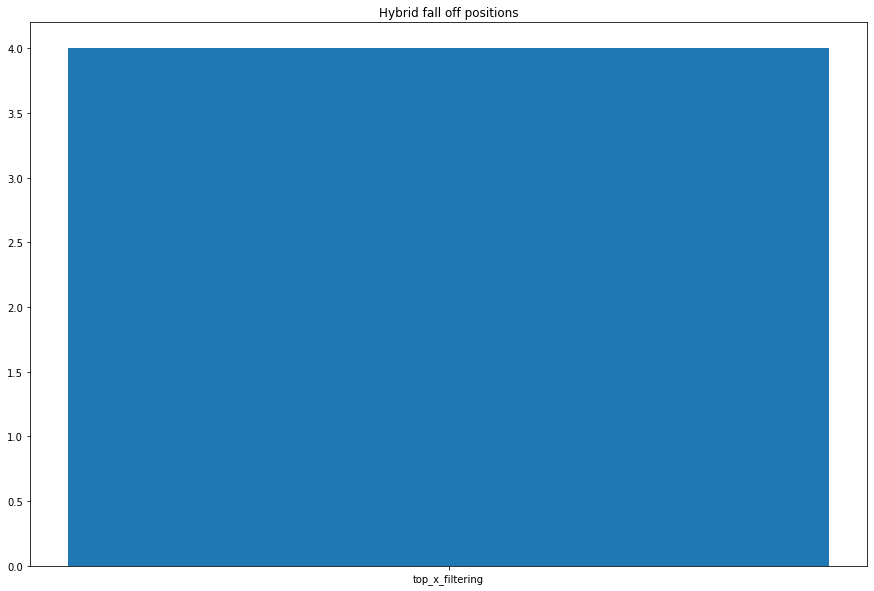

In [10]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

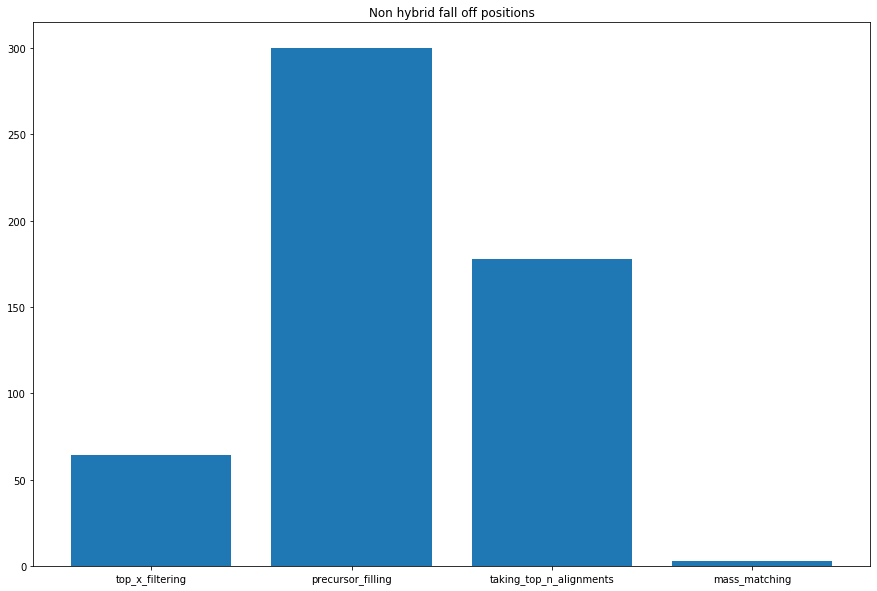

In [11]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')